# 1. import





In [ ]:
!pip install pydicom
!pip install kornia
!pip install fastai --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import zipfile as zf
import os
from pathlib import Path
import random
import shutil

import torch
import fastai
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai import *
from fastai.vision import *

In [ ]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 데이터

In [ ]:
!ls
!ls "/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project"

drive  sample_data
 checkpoint    densenet121.pt	  'google net trial.ipynb'   Resnet.ipynb
 dataset       densenet.ipynb	  'model 확인.ipynb'
 dataset.zip  'google net.ipynb'   multi-trash.zip


In [ ]:
files = zf.ZipFile("/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset.zip",'r')
files.extractall()
files.close()

In [ ]:
!ls

dataset  drive	sample_data


In [ ]:
# 2가지 class의 쓰레기 이미지 10개
files = zf.ZipFile("/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/multi-trash.zip",'r')
files.extractall()
files.close()
!ls

dataset      trash9990.jpg  trash9993.jpg  trash9996.jpg  trash9999.jpg
drive	     trash9991.jpg  trash9994.jpg  trash9997.jpg
sample_data  trash9992.jpg  trash9995.jpg  trash9998.jpg


In [ ]:
os.listdir(os.path.join(os.getcwd(), "dataset"))

['metal', 'plastic', 'cardboard', 'glass', 'paper', 'trash']

In [ ]:
path = Path(os.getcwd())/"dataset"
path

Path('/content/dataset')

In [ ]:
def list_dataset():
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            print(os.path.join(dirname, filename))


# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]

In [ ]:
import re

IMAGES_DIR = path

train_file = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_train.txt'
val_file   = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_val.txt'
test_file  = '/content/drive/MyDrive/Colab Notebooks/수업/데이터기반 인공지능/team project/dataset/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(test_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 431 samples.


In [ ]:
df_test.head()

,rel_path,label
0,paper/paper70.jpg,paper
1,paper/paper380.jpg,paper
2,cardboard/cardboard31.jpg,cardboard
3,glass/glass12.jpg,glass
4,paper/paper169.jpg,paper


In [ ]:
# 인덱싱에 따라 파일 이름을 구하기
def get_names(waste_type, indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)

# 파일의 위치를 옮기는 함수
def move_files(source_files, destination_folder):
    for file in source_files:
        shutil.move(file, destination_folder)

In [ ]:
# 데이터 종류 / 쓰레기 타입 설정
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

# data/데이터 종류/쓰레기 타입 디렉토리가 존재하지 않으면 폴더를 생성한다.
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data', subset, waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

# test 폴더는 쓰레기 타입 디렉토리가 포함되지 않으므로 따로 작성
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))

# 각 쓰레기 타입별로
source_folder = os.path.join('/content/dataset')

# 파일들을 train 폴더로 옮김
for i in range(0, df_train.shape[0]) :
  train_source_files = [os.path.join(source_folder, df_train.iloc[i,0])]
  move_files(train_source_files, "data/train/" + df_train.iloc[i,1])

# 파일들을 valid 폴더로 옮김
for i in range(0, df_valid.shape[0]) :
  valid_source_files = [os.path.join(source_folder, df_valid.iloc[i,0])]
  move_files(valid_source_files, "data/valid/" + df_valid.iloc[i,1])

# 파일들을 test폴더로 옮김
for i in range(0, df_test.shape[0]) :
  test_source_files = [os.path.join(source_folder, df_test.iloc[i,0])]
  move_files(test_source_files,"data/test/")

In [ ]:
!ls
# 2가지 class의 쓰레기 이미지 10개는 모두 test 데이터로 사용한다.
!mv trash999*.jpg data/test
!ls

data	 sample_data	trash9992.jpg  trash9995.jpg  trash9998.jpg
dataset  trash9990.jpg	trash9993.jpg  trash9996.jpg  trash9999.jpg
drive	 trash9991.jpg	trash9994.jpg  trash9997.jpg
data  dataset  drive  sample_data


In [ ]:
# 2가지 class의 쓰레기 이미지를 만드는데 사용된 본래 이미지는 train 및 valid 데이터에서 삭제한다.
# train 폴더 안에 대해서 수행
!rm data/train/cardboard/cardboard147.jpg data/train/cardboard/cardboard109.jpg data/train/cardboard/cardboard294.jpg
!rm data/train/glass/glass93.jpg data/train/glass/glass103.jpg data/train/glass/glass39.jpg data/train/glass/glass11.jpg
!rm data/train/metal/metal190.jpg data/train/metal/metal36.jpg data/train/metal/metal14.jpg
!rm data/train/paper/paper305.jpg data/train/paper/paper143.jpg data/train/paper/paper396.jpg
!rm data/train/plastic/plastic234.jpg data/train/plastic/plastic171.jpg data/train/plastic/plastic88.jpg data/train/plastic/plastic406.jpg data/train/plastic/plastic236.jpg
!rm data/train/trash/trash36.jpg data/train/trash/trash5.jpg

rm: cannot remove 'data/train/glass/glass39.jpg': No such file or directory
rm: cannot remove 'data/train/paper/paper143.jpg': No such file or directory
rm: cannot remove 'data/train/paper/paper396.jpg': No such file or directory
rm: cannot remove 'data/train/plastic/plastic88.jpg': No such file or directory
rm: cannot remove 'data/train/trash/trash36.jpg': No such file or directory


In [ ]:
# valid 폴더 안에 대해서 수행
!rm data/valid/cardboard/cardboard147.jpg data/valid/cardboard/cardboard109.jpg data/valid/cardboard/cardboard294.jpg
!rm data/valid/glass/glass93.jpg data/valid/glass/glass103.jpg data/valid/glass/glass39.jpg data/valid/glass/glass11.jpg
!rm data/valid/metal/metal190.jpg data/valid/metal/metal36.jpg data/valid/metal/metal14.jpg
!rm data/valid/paper/paper305.jpg data/valid/paper/paper143.jpg data/valid/paper/paper396.jpg
!rm data/valid/plastic/plastic234.jpg data/valid/plastic/plastic171.jpg data/valid/plastic/plastic88.jpg data/valid/plastic/plastic406.jpg data/valid/plastic/plastic236.jpg
!rm data/valid/trash/trash36.jpg data/valid/trash/trash5.jpg

rm: cannot remove 'data/valid/cardboard/cardboard147.jpg': No such file or directory
rm: cannot remove 'data/valid/cardboard/cardboard109.jpg': No such file or directory
rm: cannot remove 'data/valid/cardboard/cardboard294.jpg': No such file or directory
rm: cannot remove 'data/valid/glass/glass93.jpg': No such file or directory
rm: cannot remove 'data/valid/glass/glass103.jpg': No such file or directory
rm: cannot remove 'data/valid/glass/glass11.jpg': No such file or directory
rm: cannot remove 'data/valid/metal/metal190.jpg': No such file or directory
rm: cannot remove 'data/valid/metal/metal36.jpg': No such file or directory
rm: cannot remove 'data/valid/metal/metal14.jpg': No such file or directory
rm: cannot remove 'data/valid/paper/paper305.jpg': No such file or directory
rm: cannot remove 'data/valid/paper/paper143.jpg': No such file or directory
rm: cannot remove 'data/valid/paper/paper396.jpg': No such file or directory
rm: cannot remove 'data/valid/plastic/plastic234.jpg': N

In [ ]:
!ls
!ls data

data  dataset  drive  sample_data
test  train  valid


In [ ]:
path = Path(os.getcwd())/"data"
tfms = aug_transforms(do_flip=True, flip_vert=True)
data = ImageDataLoaders.from_folder(path, test="test", ds_tfms=tfms, bs=16, num_classes=6)
data

In [ ]:
data.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

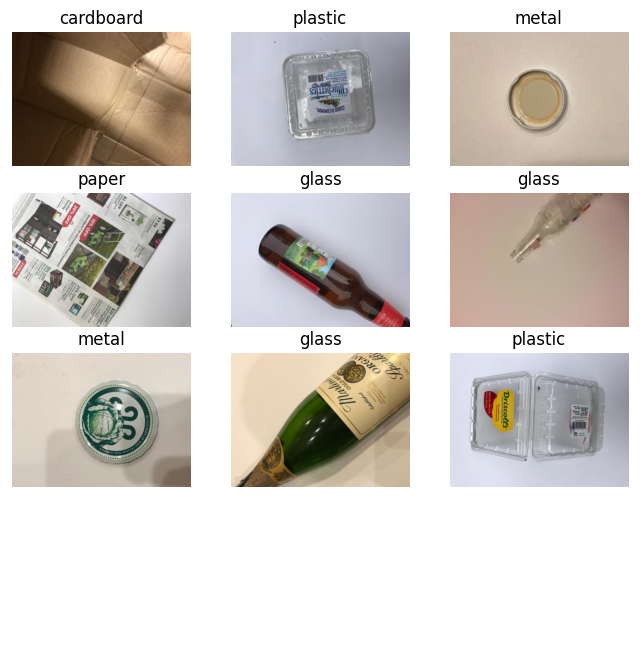

In [ ]:
data.show_batch(nrows=4, figsize=(8,8))

# 3. 모델링

In [ ]:
from fastai.vision.all import *

# 데이터 경로 설정
data_path = Path('/content/data')

# 이미지 데이터 로드
from PIL import Image
from torchvision.transforms import functional as F

custom_transforms = aug_transforms(
    do_flip=True,
    flip_vert=True,
    max_rotate=30,
    max_zoom=1.3,
    max_warp=0.2,
)
#shear_range는 fastai내 함수에 없어서 제외

data = ImageDataLoaders.from_folder(
    data_path,
    train='train',
    valid='valid',
    test='test',
    item_tfms=Resize(224),
    batch_tfms=[*custom_transforms, IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
)

# 모델 생성
learn = vision_learner(data, densenet201, metrics=[accuracy, error_rate])

# 콜백 정의
save_model_callback = SaveModelCallback(monitor='accuracy', fname='best_model', with_opt=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 241MB/s]


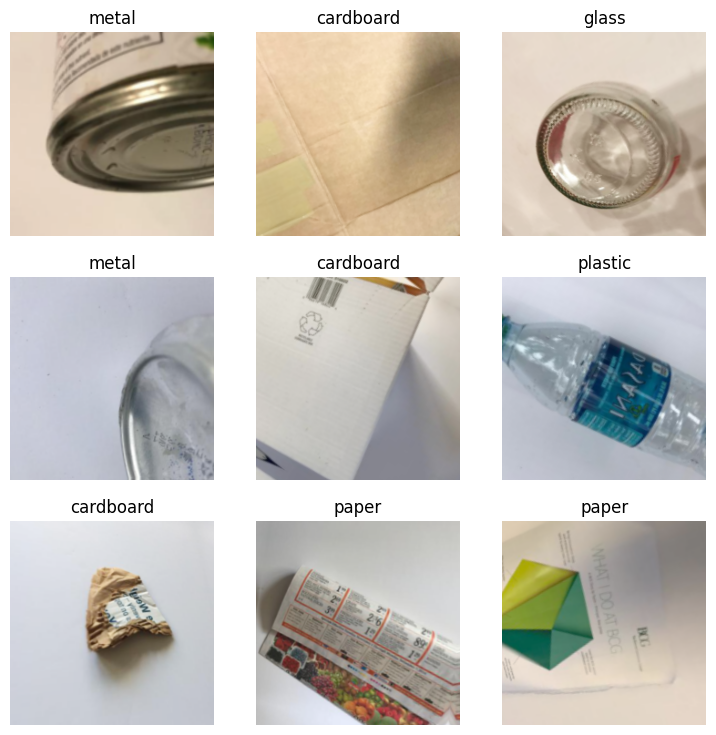

In [ ]:
data.show_batch()

SuggestedLRs(valley=0.000630957365501672)

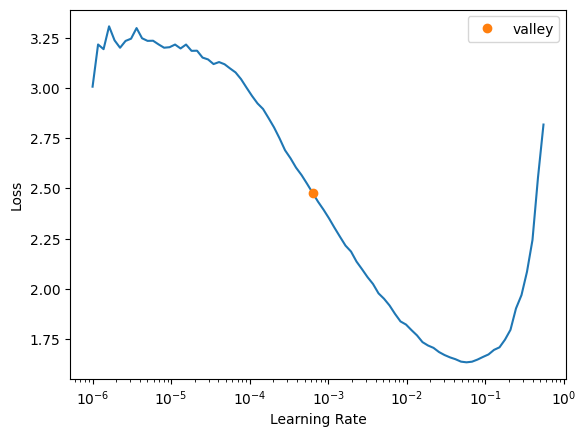

In [ ]:
learn.lr_find(start_lr=1e-6, end_lr=1e1)

In [ ]:
from fastai.vision.all import *
import torch.nn as nn

# 손실 함수 정의
loss_func = nn.CrossEntropyLoss()

# 최적화 알고리즘 정의
optimizer = Adam(learn.parameters(), lr=0.000630957365501672)

In [ ]:
learn.fine_tune(100, base_lr=0.000630957365501672, cbs=save_model_callback)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.845098,0.612036,0.782209,0.217791,00:27


Better model found at epoch 0 with accuracy value: 0.7822085618972778.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.800074,0.560699,0.797546,0.202454,00:34
1,0.744599,0.492239,0.831288,0.168712,00:33
2,0.683539,0.415164,0.846626,0.153374,00:35
3,0.629937,0.385928,0.858896,0.141104,00:33
4,0.574760,0.361192,0.865031,0.134969,00:34
5,0.532667,0.328580,0.889571,0.110429,00:33
6,0.488390,0.311492,0.889571,0.110429,00:33
7,0.443729,0.310685,0.886503,0.113497,00:35
8,0.390917,0.299684,0.901841,0.098160,00:34
9,0.360659,0.279312,0.914110,0.085890,00:34


Better model found at epoch 0 with accuracy value: 0.7975460290908813.
Better model found at epoch 1 with accuracy value: 0.8312883377075195.
Better model found at epoch 2 with accuracy value: 0.8466257452964783.
Better model found at epoch 3 with accuracy value: 0.8588957190513611.
Better model found at epoch 4 with accuracy value: 0.8650306463241577.
Better model found at epoch 5 with accuracy value: 0.8895705342292786.
Better model found at epoch 8 with accuracy value: 0.9018405079841614.
Better model found at epoch 9 with accuracy value: 0.9141104221343994.
Better model found at epoch 11 with accuracy value: 0.9233129024505615.
Better model found at epoch 12 with accuracy value: 0.9325153231620789.
Better model found at epoch 17 with accuracy value: 0.9355828166007996.
Better model found at epoch 25 with accuracy value: 0.9447852969169617.
Better model found at epoch 26 with accuracy value: 0.9478527903556824.
Better model found at epoch 29 with accuracy value: 0.9509202241897583.


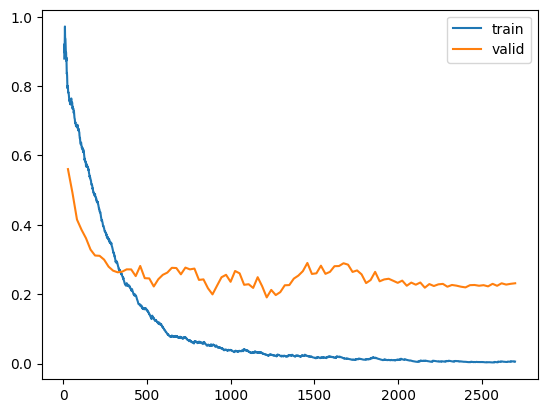

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.load('best_model')

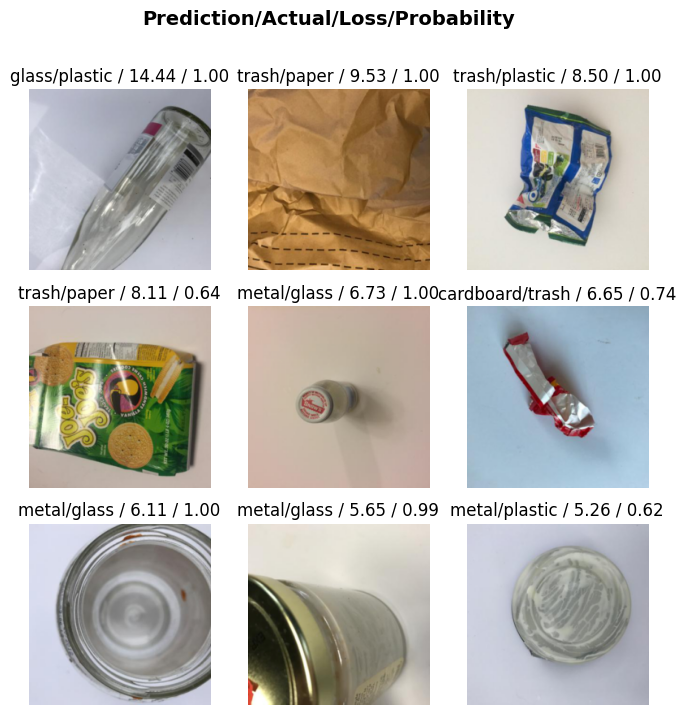

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8,8))

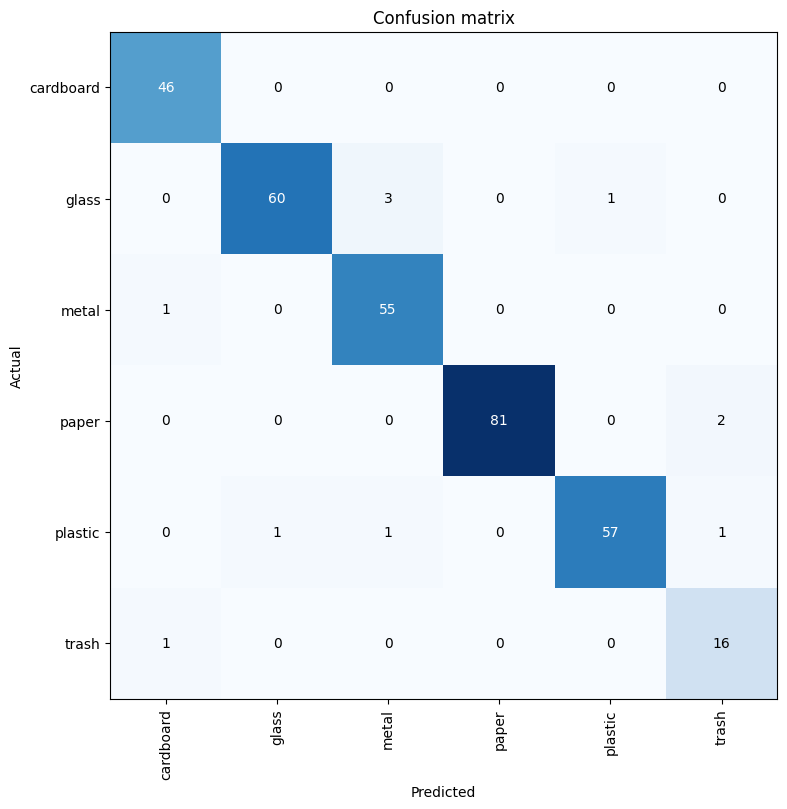

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
# 가장 혼동되는 조합 정렬
interp.most_confused()

[('glass', 'metal', 3),
 ('paper', 'trash', 2),
 ('glass', 'plastic', 1),
 ('metal', 'cardboard', 1),
 ('plastic', 'glass', 1),
 ('plastic', 'metal', 1),
 ('plastic', 'trash', 1),
 ('trash', 'cardboard', 1)]

# 4. 테스트

In [ ]:
test_items = get_image_files('/content/data/test')
test_dl = learn.dls.test_dl(test_items, rm_type_tfms=1, bs=64)

# 예측 수행
preds, _ = learn.get_preds(dl=test_dl)

# 결과 출력
print(preds.shape)
print(preds)

torch.Size([441, 6])
tensor([[9.1207e-09, 3.1158e-03, 3.0862e-09, 7.3000e-09, 9.9688e-01, 1.9471e-06],
        [1.0000e+00, 3.9099e-09, 6.1298e-09, 3.8918e-10, 1.4687e-10, 2.6307e-08],
        [1.1508e-01, 2.0113e-09, 3.3511e-08, 8.8491e-01, 1.1073e-06, 3.0738e-06],
        ...,
        [7.4939e-10, 8.1621e-12, 8.6783e-12, 1.0000e+00, 1.2660e-10, 9.6133e-10],
        [1.0000e+00, 1.4734e-13, 2.5070e-11, 2.9756e-12, 4.5826e-14, 2.6952e-09],
        [4.5374e-09, 9.7638e-08, 2.5876e-07, 9.9999e-01, 2.0329e-06, 6.7904e-06]])


In [ ]:
data.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# 각 이미지의 tensor 최대값의 위치 번호를 부여
max_idxs = np.asarray(torch.argmax(preds, dim=1))
max_idxs

array([4, 0, 3, 1, 3, 1, 0, 0, 4, 3, 4, 1, 3, 4, 1, 3, 3, 1, 3, 3, 0, 4,
       1, 1, 3, 2, 4, 4, 4, 5, 4, 3, 3, 1, 1, 0, 0, 4, 4, 5, 3, 3, 3, 2,
       4, 2, 4, 2, 0, 1, 3, 4, 4, 4, 4, 4, 1, 4, 1, 2, 5, 3, 1, 1, 3, 3,
       3, 3, 4, 0, 4, 2, 2, 2, 4, 3, 2, 3, 2, 3, 0, 3, 3, 2, 2, 4, 2, 2,
       4, 3, 1, 4, 4, 5, 2, 3, 3, 3, 0, 2, 5, 3, 1, 0, 0, 3, 4, 3, 1, 4,
       5, 0, 0, 1, 4, 3, 3, 3, 1, 1, 2, 1, 1, 3, 1, 0, 3, 2, 5, 3, 0, 2,
       3, 3, 2, 3, 3, 1, 5, 1, 1, 0, 1, 2, 2, 3, 0, 3, 4, 1, 2, 2, 1, 2,
       0, 0, 3, 2, 1, 4, 0, 1, 2, 5, 2, 3, 2, 4, 0, 1, 0, 3, 5, 4, 5, 2,
       3, 0, 4, 4, 3, 0, 5, 0, 1, 1, 1, 3, 1, 1, 4, 1, 4, 5, 3, 2, 4, 1,
       1, 1, 0, 5, 2, 2, 2, 3, 5, 4, 2, 3, 3, 3, 3, 4, 2, 3, 0, 4, 0, 3,
       3, 1, 0, 3, 2, 0, 0, 1, 3, 1, 2, 1, 3, 0, 2, 4, 2, 4, 0, 4, 2, 4,
       4, 3, 1, 2, 0, 1, 3, 1, 1, 0, 2, 3, 2, 0, 0, 3, 2, 1, 4, 3, 4, 2,
       2, 0, 0, 0, 2, 3, 3, 4, 4, 3, 1, 2, 0, 0, 4, 1, 0, 4, 1, 2, 1, 3,
       3, 2, 4, 3, 5, 4, 3, 1, 1, 4, 0, 5, 1, 2, 1,

In [ ]:
# 부여된 번호를 토대로 class의 이름을 부여
yhat = []
for max_idx in max_idxs:
    yhat.append(data.vocab[max_idx])

# yhat은 모든 이미지가 1가지 class를 가진다고 가정했을 때 예측값
print(yhat)

['plastic', 'cardboard', 'paper', 'glass', 'paper', 'glass', 'cardboard', 'cardboard', 'plastic', 'paper', 'plastic', 'glass', 'paper', 'plastic', 'glass', 'paper', 'paper', 'glass', 'paper', 'paper', 'cardboard', 'plastic', 'glass', 'glass', 'paper', 'metal', 'plastic', 'plastic', 'plastic', 'trash', 'plastic', 'paper', 'paper', 'glass', 'glass', 'cardboard', 'cardboard', 'plastic', 'plastic', 'trash', 'paper', 'paper', 'paper', 'metal', 'plastic', 'metal', 'plastic', 'metal', 'cardboard', 'glass', 'paper', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'glass', 'plastic', 'glass', 'metal', 'trash', 'paper', 'glass', 'glass', 'paper', 'paper', 'paper', 'paper', 'plastic', 'cardboard', 'plastic', 'metal', 'metal', 'metal', 'plastic', 'paper', 'metal', 'paper', 'metal', 'paper', 'cardboard', 'paper', 'paper', 'metal', 'metal', 'plastic', 'metal', 'metal', 'plastic', 'paper', 'glass', 'plastic', 'plastic', 'trash', 'metal', 'paper', 'paper', 'paper', 'cardboard', 'metal', 'trash'

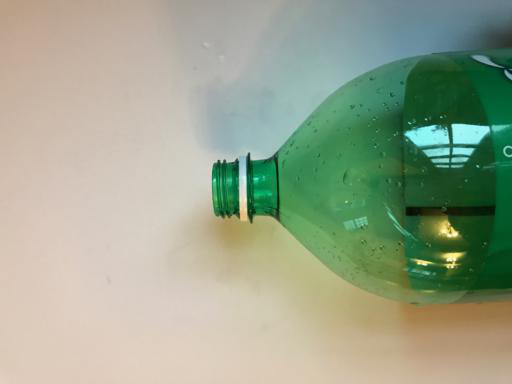

In [ ]:
test_ds = test_dl.dataset
test_ds[0][0]

In [ ]:
y = []
for label_path in test_items:
    y.append(str(label_path))

multiClass_pred_index = []
for i in range(10) :
    multiClass_pred_index.append(y.index('/content/data/test/trash999'+ str(i) + '.jpg'))

pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

print(y)
print(multiClass_pred_index)

['plastic', 'cardboard', 'trash', 'glass', 'paper', 'glass', 'cardboard', 'cardboard', 'plastic', 'paper', 'plastic', 'trash', 'paper', 'plastic', 'glass', 'paper', 'paper', 'glass', 'trash', 'paper', 'cardboard', 'plastic', 'glass', 'glass', 'paper', 'metal', 'plastic', 'plastic', 'plastic', 'trash', 'plastic', 'paper', 'paper', 'glass', 'glass', 'cardboard', 'cardboard', 'plastic', 'plastic', 'trash', 'paper', 'paper', 'paper', 'metal', 'plastic', 'metal', 'plastic', 'metal', 'cardboard', 'glass', 'paper', 'plastic', 'plastic', 'trash', 'plastic', 'plastic', 'glass', 'plastic', 'glass', 'metal', 'trash', 'paper', 'glass', 'glass', 'paper', 'paper', 'paper', 'paper', 'plastic', 'cardboard', 'plastic', 'metal', 'metal', 'metal', 'plastic', 'paper', 'metal', 'paper', 'metal', 'paper', 'cardboard', 'paper', 'paper', 'metal', 'metal', 'plastic', 'metal', 'metal', 'plastic', 'paper', 'glass', 'trash', 'plastic', 'paper', 'glass', 'paper', 'paper', 'paper', 'cardboard', 'metal', 'trash', 'p

In [ ]:
# 예측값
print(yhat[0:5])
# 실제값
print(y[0:5])

['plastic', 'cardboard', 'paper', 'glass', 'paper']
['plastic', 'cardboard', 'trash', 'glass', 'paper']


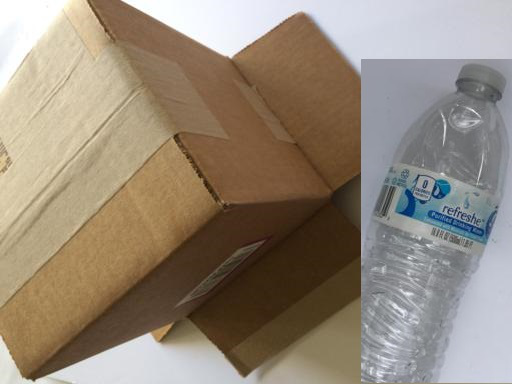

In [ ]:
# multiClass 첫번째 이미지 확인
test_ds[multiClass_pred_index[0]][0]

In [ ]:
# multiClass 이미지들의 tensor 값 확인
for i in multiClass_pred_index :
    print(learn.predict(test_ds[i][0])[2] )
# data.classes : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

tensor([1.0000e+00, 6.0011e-10, 1.0515e-08, 5.7446e-08, 1.2990e-06, 1.6169e-08])


tensor([6.0049e-03, 9.6199e-01, 3.1864e-02, 1.1110e-04, 1.2757e-07, 3.5172e-05])


tensor([1.1219e-02, 2.5456e-07, 1.0312e-01, 8.8362e-01, 1.6364e-05, 2.0249e-03])


tensor([3.1818e-02, 9.6816e-01, 1.9039e-06, 2.2437e-09, 1.4210e-06, 1.6434e-05])


tensor([7.7916e-08, 9.4221e-05, 8.5284e-06, 7.6454e-03, 9.8706e-01, 5.1877e-03])


tensor([1.7316e-09, 2.6158e-09, 6.7349e-08, 1.0000e+00, 1.1151e-07, 2.7626e-08])


tensor([1.1509e-01, 2.0113e-09, 3.3511e-08, 8.8491e-01, 1.1073e-06, 3.0738e-06])


tensor([5.8122e-06, 6.6105e-06, 3.2386e-02, 4.7245e-07, 9.6757e-01, 2.7564e-05])


tensor([1.2830e-06, 6.0315e-01, 5.5607e-05, 4.8007e-07, 3.9677e-01, 2.7234e-05])


tensor([1.8103e-06, 9.9629e-01, 6.3718e-06, 3.8701e-06, 2.8211e-03, 8.7898e-04])


In [ ]:
# multiClass 이미지에 대해서만 결과 출력
for i in multiClass_pred_index :
    # display(learn.data.test_ds[i][0])
    result = learn.predict(test_ds[i][0])[2]
    print(result)
    for index, value in enumerate(result) :
        # print(value, data.classes[index])
        if value > 0.01 :
            print(value, data.vocab[index])

tensor([1.0000e+00, 6.0011e-10, 1.0515e-08, 5.7446e-08, 1.2990e-06, 1.6169e-08])
tensor(1.0000) cardboard


tensor([6.0049e-03, 9.6199e-01, 3.1864e-02, 1.1110e-04, 1.2757e-07, 3.5172e-05])
tensor(0.9620) glass
tensor(0.0319) metal


tensor([1.1219e-02, 2.5456e-07, 1.0312e-01, 8.8362e-01, 1.6364e-05, 2.0249e-03])
tensor(0.0112) cardboard
tensor(0.1031) metal
tensor(0.8836) paper


tensor([3.1818e-02, 9.6816e-01, 1.9039e-06, 2.2437e-09, 1.4210e-06, 1.6434e-05])
tensor(0.0318) cardboard
tensor(0.9682) glass


tensor([7.7916e-08, 9.4221e-05, 8.5284e-06, 7.6454e-03, 9.8706e-01, 5.1877e-03])
tensor(0.9871) plastic


tensor([1.7316e-09, 2.6158e-09, 6.7349e-08, 1.0000e+00, 1.1151e-07, 2.7626e-08])
tensor(1.0000) paper


tensor([1.1509e-01, 2.0113e-09, 3.3511e-08, 8.8491e-01, 1.1073e-06, 3.0738e-06])
tensor(0.1151) cardboard
tensor(0.8849) paper


tensor([5.8122e-06, 6.6105e-06, 3.2386e-02, 4.7245e-07, 9.6757e-01, 2.7564e-05])
tensor(0.0324) metal
tensor(0.9676) plastic


tensor([1.2830e-06, 6.0315e-01, 5.5607e-05, 4.8007e-07, 3.9677e-01, 2.7234e-05])
tensor(0.6031) glass
tensor(0.3968) plastic


tensor([1.8103e-06, 9.9629e-01, 6.3718e-06, 3.8701e-06, 2.8211e-03, 8.7898e-04])
tensor(0.9963) glass


In [ ]:
# 모든 이미지에 대해서 결과 저장
yhat2 = []
for i in range(len(test_items)) :
    # display(learn.data.test_ds[i][0])
    result = learn.predict(test_ds[i][0])[2]
    # print(result)
    trashClass = ""
    for index, value in enumerate(result) :
        # print(value, data.classes[index])
        if value > 0.01 :
            if trashClass == "" : trashClass = data.vocab[index]
            else : trashClass += " & " + data.vocab[index]
            # print(value, data.classes[index])
    yhat2.append(trashClass)

# yhat2는 각 이미지에 대해 임계값이 넘는 class를 모두 출력 : ex) 'glass & metal & plastic'
print(yhat2)

['plastic', 'cardboard', 'cardboard & paper', 'glass', 'paper', 'glass', 'cardboard', 'cardboard', 'paper & plastic', 'paper', 'plastic', 'glass', 'paper', 'plastic', 'glass', 'paper', 'paper', 'glass', 'cardboard & metal & paper', 'paper', 'cardboard', 'plastic', 'glass', 'glass', 'paper', 'metal', 'plastic', 'plastic', 'plastic', 'trash', 'plastic', 'paper', 'paper', 'glass', 'glass & metal', 'cardboard', 'cardboard', 'plastic', 'plastic', 'paper & plastic & trash', 'paper', 'paper', 'cardboard & paper', 'metal', 'plastic', 'metal', 'plastic', 'metal', 'cardboard', 'glass', 'paper', 'plastic', 'plastic', 'metal & plastic', 'plastic', 'plastic', 'glass', 'plastic', 'glass', 'metal', 'trash', 'paper', 'glass', 'glass', 'paper', 'paper', 'paper', 'paper', 'glass & plastic', 'cardboard', 'plastic', 'metal', 'metal', 'metal', 'plastic', 'paper', 'metal', 'paper', 'cardboard & metal', 'paper', 'cardboard', 'paper', 'paper', 'metal', 'metal', 'plastic', 'metal', 'metal', 'plastic', 'paper',

In [ ]:
# yhat3은 yhat2에서 '&' 문자를 가지고 있는 경우에 일괄적으로 'multi'라고 저장.
yhat3 = list(yhat2)
for i in range(len(yhat3)) :
    if '&' in yhat3[i] :
        yhat3[i] = "multi"

# multiClass 이미지는 y에 'trash'라고 저장되어 있지만, y3에서는 'multi'라고 저장
y3 = list(y)
for i in multiClass_pred_index :
    y3[i] = "multi"

[[ 67   0   0   1   0   0   2]
 [  0  73   0   0   1   0   8]
 [  0   0  63   0   0   0   5]
 [  0   0   0 102   0   0   6]
 [  0   1   0   0  63   0  10]
 [  0   0   0   0   1  20   8]
 [  1   1   0   1   1   0   6]]


<Axes: >

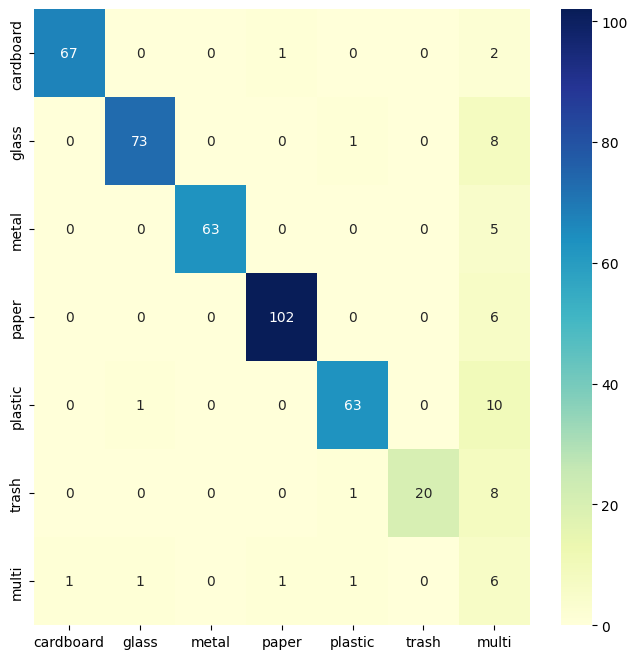

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y3, yhat3, labels=waste_types+["multi"])
print(cm)

import seaborn as sns
df_cm = pd.DataFrame(cm, waste_types + ["multi"], waste_types + ["multi"])

plt.figure(figsize=(8,8))
sns.heatmap(df_cm,annot=True, fmt="d", cmap="YlGnBu")

In [ ]:
count = 0
for i in range(len(y3)) :
    if y[i] != "multi" and y[i] == yhat3[i] :
        count += 1

count += 6
print("accuracy :", count / len(y3) * 100)

accuracy : 89.34240362811792


In [ ]:
# 리눅스 상에 저장된 폴더를 삭제함.
shutil.rmtree("data")
shutil.rmtree("dataset")

In [ ]:
!ls

drive  sample_data
